# Cycle GANs

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

## Importamos el Dataset

In [15]:
dataset, metadata = tfds.load('cycle_gan/vangogh2photo',
                              with_info=True, as_supervised=True)

train_van, train_photos = dataset['trainA'], dataset['trainB']
test_van, test_photos = dataset['testA'], dataset['testB']

## Funciones para gregar ruido y tests de ruido
Ponemos tamaños de jitter y resize, luego vemos que le están haciendo a algunas fotoos

In [16]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [17]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image, label):
  image = normalize(image)
  return image

train_photos = train_photos.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_van = train_van.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_photos = test_photos.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_van = test_van.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

sample_photo = next(iter(train_photos))
sample_van = next(iter(train_van))


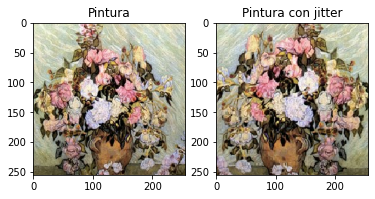

In [152]:
sample_van = next(iter(train_van))
plt.subplot(121)
plt.title('Pintura')
plt.imshow(sample_van[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Pintura con jitter')
plt.imshow(random_jitter(sample_van[0]) * 0.5 + 0.5)


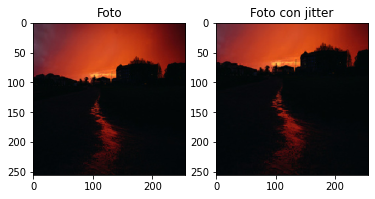

In [275]:
sample_photo = next(iter(train_photos))
plt.subplot(121)
plt.title('Foto')
plt.imshow(sample_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Foto con jitter')
plt.imshow(random_jitter(sample_photo[0]) * 0.5 + 0.5)


## Importamos y reusamos el modelo de Pix2Pix

Los bajamos de tensorflow_examples
* Usa Instance Normalization en lugar de batch Normalization
* Por simplicidad usamos generador basado en resnet y no en unet

Habrá 2 generadores, G y F con 2 discriminadores X & Y
* G: X -> Y
* F: Y -> X
* Dx diferencía entre X y X (F(Y))
* Dy diferencía entre Y y Y (F(X))
![alt text](3.png "GAN")

In [38]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

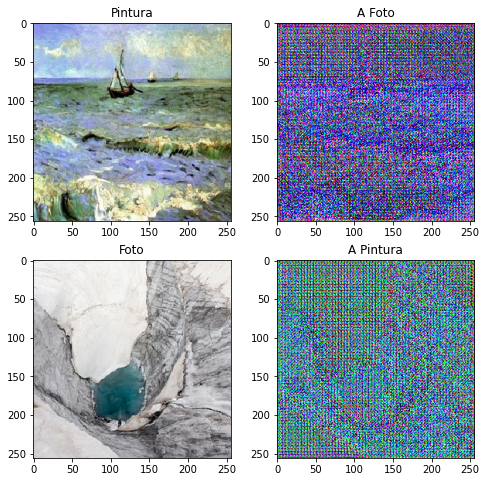

In [50]:
to_photo = generator_g(sample_van)
to_van = generator_f(sample_photo)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_van, to_photo, sample_photo, to_van]
title = ['Pintura', 'A Foto', 'Foto', 'A Pintura']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()


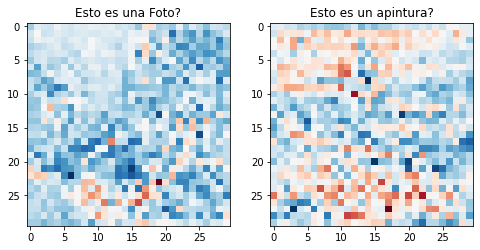

In [40]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Esto es una Foto?')
plt.imshow(discriminator_y(sample_photo)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Esto es un apintura?')
plt.imshow(discriminator_x(sample_van)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Función de pérdida
Como es no supervisado no podemos garantizar que input y output sean algo significativo.
En el paper se propone cycle consistency loss

In [41]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [42]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5


In [43]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

La consistencia de ciclo busca que el output sea parecido al input. Si traduces de Caballo a Cebra y regresas esa Cebra a Caballo buscas tener lo mismo.

Pérdida de consistencia en cíclo:
   * Conviertes X a Y_1 usando G
   * Regresas Y_1 al dominio de Xs (X_1)usando F
   * Sacas al error medio absoluto entre X y X_1
   
![alt text](4.png "Consist")

Buscamos que las fotos no pierdan su "identidad", esto es; que sean muy parecidas a las 
originales. Medimos la pérduda de identidad con:
* Ident_loss = |G(Y)-Y| + |F(X)-X|

In [44]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss


## Optimizadores
* Usamos Adam.

In [45]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


## Checkpoints
* Guardamos checkpoints para poder usar nuestra red entrenada después

In [46]:
checkpoint_path = "./checkpointsProy/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')


## Entrenamiento

In [47]:
EPOCHS = 200

In [48]:
def generate_images(model, test_input):
  prediction = model(test_input)       #Toma predicciones del input

  plt.figure(figsize=(12, 12))    

  display_list = [test_input[0], prediction[0]]  
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()


In [49]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    #Lleva y regresa imagenes a los dominios
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    #Pasamos de X a X y de Y a Y para comparar las identidades más fácil
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)
    
    #Usamos Discriminadores
    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    #Calcula pérdida del generador
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    #Calculamos pérdida total del cíclo
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    #Calculamos pérdidas totales de cara generador
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
    
    #Calculamos pérduda comparando las imagenes traducidas a los dos dominios con 
    #las que originalmente están en cada dominio
    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  #Calcula Gradientes
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  #Aplicamos gradientes a optimizadores (ADAM)
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))


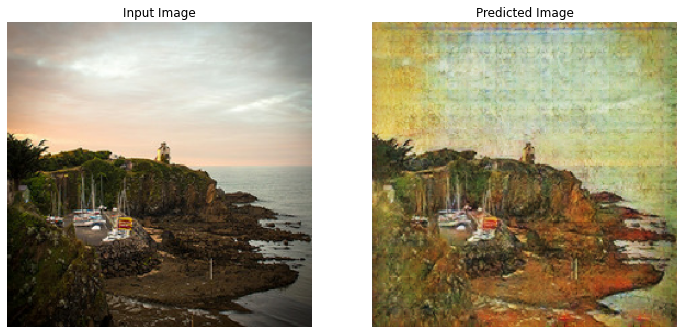

Saving checkpoint for epoch 200 at ./checkpointsProy/train/ckpt-40
Time taken for epoch 200 is 191.84271883964539 sec



In [59]:
#Ciclo de entrenamiento
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_van, train_photos)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_f, sample_photo)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))


## Resultados

### Primero sobre el Dataset que usamos

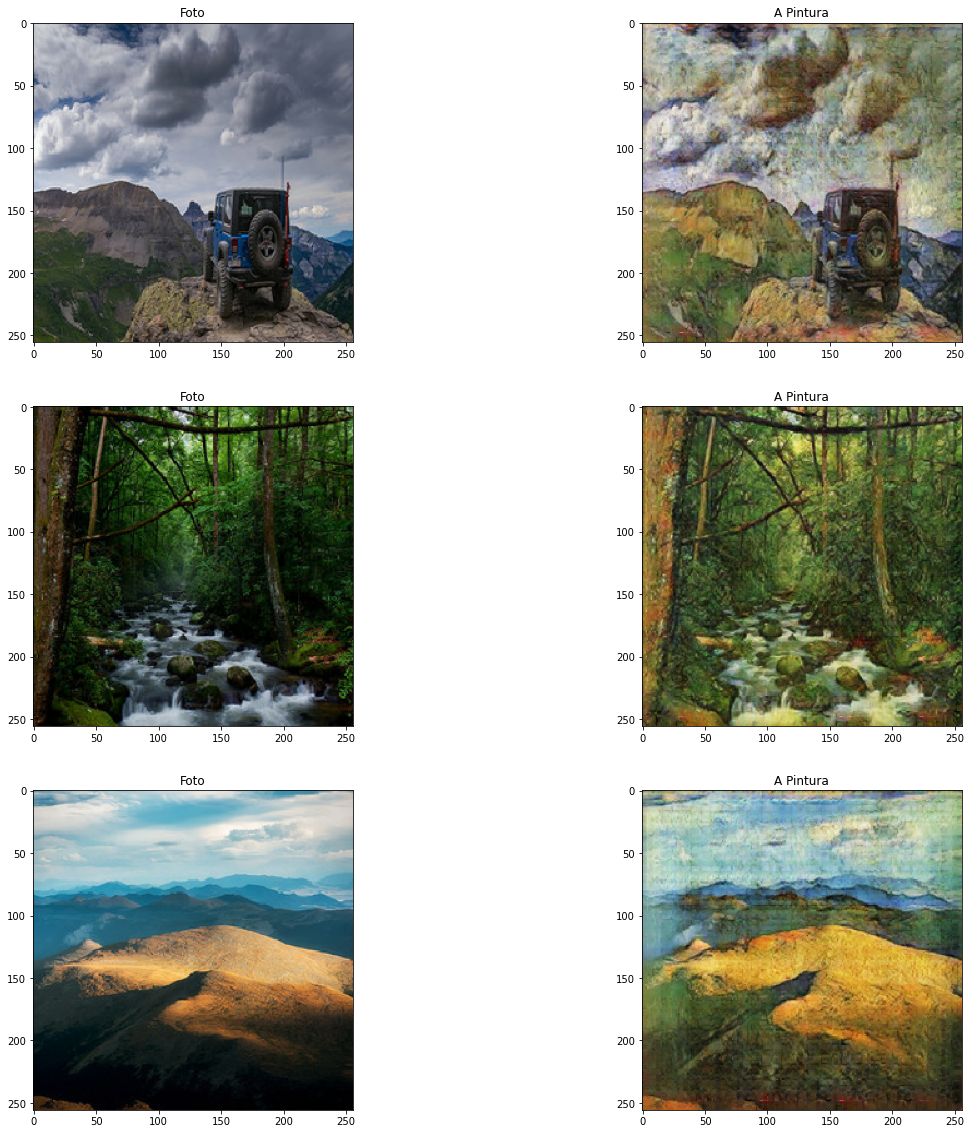

In [463]:
#sample_van = next(iter(train_van))
sample_photos1 = next(iter(train_photos))
#sample_photos2 = next(iter(train_photos))
#sample_photos3 = next(iter(train_photos))
#to_photo = generator_g(sample_van)
from PIL import Image
import numpy as npto_van1 = generator_f(sample_photos1)
#to_van2 = generator_f(sample_photos2)
#to_van3 = generator_f(sample_photos3)

plt.figure(figsize=(20, 20))
contrast = 8

imgs = [sample_photos1, to_van1, sample_photos2, to_van2, sample_photos3, to_van3]
title = ['Foto', 'A Pintura', 'Foto', 'A Pintura', 'Foto', 'A Pintura']

for i in range(len(imgs)):
  plt.subplot(3, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
plt.show()

### Ahora usamos imágenes externas al Dataset

* Fue muy complicado meter imágenes propias pues las teníamos que parsear a tensores pero se logró

#### Nota: Hay que poner un folder dentro de Fotos/ para que tensorflow pueda toma cualquier nombre de imagen

In [464]:
import pathlib
from PIL import Image
import numpy as np

In [465]:
data_dir = "/home/fran/Documents/ApMaq/Fotos/"  ##Path al directorio donde estan las fotos
data_dir = pathlib.Path(data_dir)

In [466]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)


10


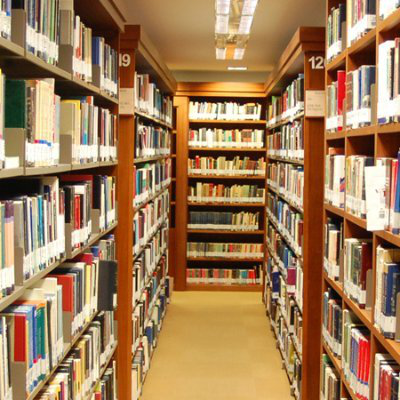

In [467]:
#Vemos si se cargaron
fotos = list(data_dir.glob('dir/*'))
PIL.Image.open(str(fotos[12]))

In [469]:
#Preprocesamos el dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 15 files belonging to 1 classes.


In [470]:
#creamos un mapa para poder iterar sobre el
train_ds = train_ds.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

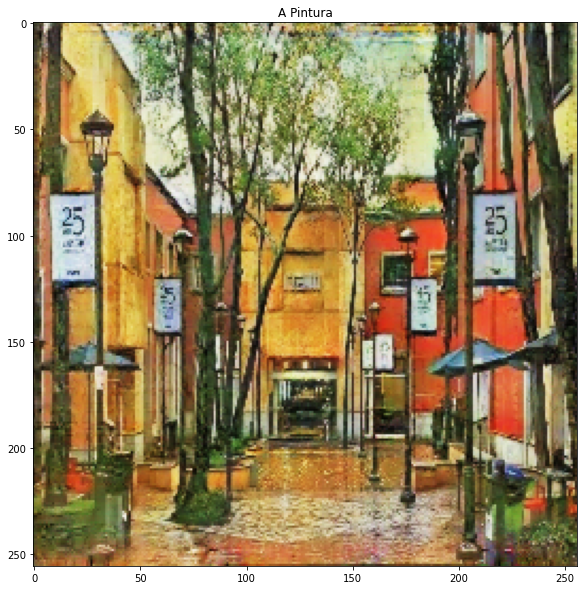

In [546]:
#Metémos imagenes al generador.
img =next(iter(train_ds))
to_van1 = generator_f(tf.squeeze(img, [0]))
plt.figure(figsize=(10, 10))
contrast = 8

imgs = [img, to_van1]
title = ['Foto', 'A Pintura']

plt.title(title[1])
plt.imshow(imgs[1][0] * 0.5 + 0.5)
plt.show()
